# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
# Необходимые обновления
# !pip install --upgrade matplotlib -q
# !pip install --upgrade pandas -q

In [2]:
import pandas as pd
import numpy as np
from random import randint 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

## Откройте и изучите файл

In [3]:
try:
    df = pd.read_csv('users_behavior.csv')
except FileNotFoundError:
    df = pd.read_csv('####')

In [4]:
display(df.describe())
display(df.info())
df.head()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Данные выглядят опрятно, но судя по описательной статистике в них должны быть выбросы.

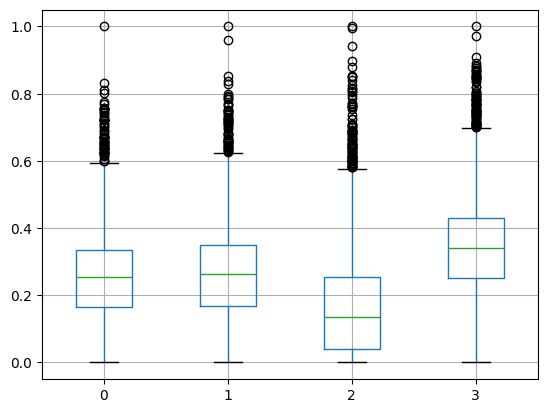

In [5]:
normalized = MinMaxScaler().fit_transform(df[df.columns.to_list()[:-1]])
pd.DataFrame(normalized).boxplot();

Выбросы действительно есть во всех признаках и их значительное количество. Не будем их удалять, возможно они пригодятся при обучении модели на краевых случаях.

## Разбейте данные на выборки

In [6]:
# Разбиваем данные на выборки
x = df.drop(['is_ultra'], axis=1)
y = df.is_ultra

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

В ячейке выше я разбил данные на 3 выборки, тренировочную, валидационную и тестовую. Тестовую оставим для финальной проверки.

## Исследуйте модели

In [7]:
# Функция для выбора лучшей модели для моделей на основе деревьев
def get_best_model(range_, model_object, random_state=7765):
    score = 0
    best_model = None
    df = {'accuracy': [], 'depth': []}
    for i in range(1, range_+1):
        model = model_object(random_state=7765, max_depth=i)
        model.fit(x_train, y_train)
        model_pred = model.predict(x_val)
        df['accuracy'].append(score_m := accuracy_score(y_val, model_pred))
        df['depth'].append(i)
        if score_m > score:
            score = score_m
            best_model = model
    display(pd.DataFrame(df).style.background_gradient('coolwarm', subset=['accuracy']))
    return best_model

Функция что-бы не писать одно и тоже 2 раза.

In [8]:
# DecisionTreeClassifier
best_tree = get_best_model(10, DecisionTreeClassifier)

,accuracy,depth
0,0.741835,1
1,0.762053,2
2,0.785381,3
3,0.797823,4
4,0.791602,5
5,0.782271,6
6,0.786936,7
7,0.788491,8
8,0.776050,9
9,0.779160,10


Лучше всего показала себя модель с максимальной глубиной ветвления 4.

In [9]:
# RandomForestClassifier
best_forest = get_best_model(10, RandomForestClassifier)

,accuracy,depth
0,0.744946,1
1,0.766719,2
2,0.791602,3
3,0.796267,4
4,0.799378,5
5,0.799378,6
6,0.802488,7
7,0.802488,8
8,0.799378,9
9,0.807154,10


Лучше всего показала себя модель с глубиной ветвления 10.

In [10]:
model_logistic = LogisticRegression(random_state=777)
model_logistic.fit(x_train, y_train)
model_pred = model_logistic.predict(x_val)
accuracy_score(y_val, model_pred)

0.7558320373250389

Логистическая регрессия тоже проходит барьер в 75%, но предсказывает хуже чем модели "на деревьях"

## Проверьте модель на тестовой выборке

In [11]:
print('Random forest accuracy score on test sample', accuracy_score(y_test, best_forest.predict(x_test)))

Random forest accuracy score on test sample 0.7947122861586314


На тестовой выборке было решено проверить модель на основе случайного леса высотой 10 ветвей так как она показала самые хорошие результаты на валидационной выборке.

__Вывод:__ В ходе работы была подготовлена модель которая с точностью 79% определяет подходящий тариф сотовой связи. Модель основана на случайном лесе высотой 10 ветвей.

## (бонус) Проверьте модели на адекватность

In [12]:
model_pred = best_forest.predict(x)
print('accuracy_score all data', score_m:=accuracy_score(y, model_pred))
i = 0
model_accuracy = [score_m]
while i < 5:
    print('try', i)
    print(r:=randint(1000, 2000), 'sample randint')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=r)
    model_pred = best_forest.predict(x_test)
    print('accuracy_score', score_m:=accuracy_score(y_test, model_pred))
    model_accuracy.append(score_m)
    i+=1
display(pd.DataFrame(model_accuracy).style.background_gradient('coolwarm'))

accuracy_score all data 0.8618543870566272
try 0
1858 sample randint
accuracy_score 0.8599875544492844
try 1
1396 sample randint
accuracy_score 0.8599875544492844
try 2
1365 sample randint
accuracy_score 0.8668326073428749
try 3
1645 sample randint
accuracy_score 0.8643434971997511
try 4
1369 sample randint
accuracy_score 0.8612321095208463


,0
0,0.861854
1,0.859988
2,0.859988
3,0.866833
4,0.864343
5,0.861232


Для проверки модели на адекватность мною было решено сделать ресемплинг и заново прогнать алгоритм случайного леса 5 раз, а также посмотреть как ведёт себя модель если подать на вход все данные. Модель показала себя лучше(от 5 до 7%) чем на оригинальной тестовой выборке и прошла проверку на адекватность. __Просьба ревьюеру указать что надо было сделать для проверки на адекватность, так как это никак не освещалось в теоретической части, всё что сделано, основано не паре беглых запросов в гугл и собственных умозаключениях, сначала вообще 5 раз тренировал новую модель на известных оптимальных гиперпараметрах, потом понял что это наверное не правильно, а проверять надо саму модель, а не параметры__

In [13]:
# Сравним модель со случайным угадыванием наиболее частого результата.
print('0 and 1 counts in dependant variable', y.value_counts())
print(f'accuracy, predicting most common entry {accuracy_score(y, np.zeros(df.shape[0])):.2f}')
model_pred = best_forest.predict(x)
print(f'accuracy_score all data, {accuracy_score(y, model_pred):.2f}')

0 and 1 counts in dependant variable is_ultra
0    2229
1     985
Name: count, dtype: int64
accuracy, predicting most common entry 0.69
accuracy_score all data, 0.86


При сравнении результатов работы модели и стабильным угадыванием самого частого результата побеждает модель. С разницей в 17% в пользу модели. Проверка на адекватность пройдена.